In [1]:
# -*- coding: utf-8 -*-
"""CINIC-10 Image Classification for Tool Sharing Platform

System built for Ashesi Business Students.
"""

'CINIC-10 Image Classification for Tool Sharing Platform\n\nSystem built for Ashesi Business Students.\n'

In [2]:
# --- 1. Install and Import Necessary Packages ---
!pip install -q torchsummary
!pip install -q tqdm
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
from torchsummary import summary

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [3]:
# --- 2. Setup: Connect to Drive and Device ---
from google.colab import drive
drive.mount('/content/drive')

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Mounted at /content/drive
Using device: cuda
PyTorch version: 2.8.0+cu126


In [4]:
# --- 3. Dataset Path Structure ---

drive_data_dir = "/content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10" # @param {type:"string"}

print(f"Using dataset path from Google Drive shortcut: {drive_data_dir}")

# Verify the path and find the actual data directory if it's in a subfolder
contents = os.listdir(drive_data_dir)
print("Contents of dataset directory:", contents)

final_data_path = drive_data_dir
# Look for 'train', 'valid', 'test' subdirectories directly in the shortcut directory
if all(os.path.exists(os.path.join(drive_data_dir, split)) for split in ['train', 'valid', 'test']):
     print(f"Found dataset splits directly in the shortcut directory.")
else:
    # If not directly there, look for a subfolder containing the splits (like the original download structure)
    found_subfolder = False
    for item in contents:
        item_path = os.path.join(drive_data_dir, item)
        if os.path.isdir(item_path) and all(os.path.exists(os.path.join(item_path, split)) for split in ['train', 'valid', 'test']):
            final_data_path = item_path
            print(f"Found dataset in subfolder: {item}")
            found_subfolder = True
            break
    if not found_subfolder:
        print("Warning: Could not find 'train', 'valid', 'test' subdirectories in the specified path or any immediate subfolder.")
        print("Please ensure the shortcut points to the correct location of the extracted CINIC-10 dataset.")


train_dir = os.path.join(final_data_path, 'train')
valid_dir = os.path.join(final_data_path, 'valid')
test_dir = os.path.join(final_data_path, 'test')

print(f"\nFinal paths:")
print(f"Train: {train_dir} - Exists: {os.path.exists(train_dir)}")
print(f"Valid: {valid_dir} - Exists: {os.path.exists(valid_dir)}")
print(f"Test: {test_dir} - Exists: {os.path.exists(test_dir)}")

Using dataset path from Google Drive shortcut: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10
Contents of dataset directory: ['valid', 'train', 'test']
Found dataset splits directly in the shortcut directory.

Final paths:
Train: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10/train - Exists: True
Valid: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10/valid - Exists: True
Test: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10/test - Exists: True


In [17]:
# --- 4a. Subset Data from Original Splits with Custom Proportions ---

total_data_percentage = 10 # @param {type:"number"}

if total_data_percentage < 0 or total_data_percentage > 100:
    print("Warning: Total data percentage should be between 0 and 100. Using 100%.", flush=True)
    total_data_percentage = 100

# Define the NEW split percentages for the SELECTED SUBSET
# These percentages will determine the proportion of images taken from the *original* splits
# to form the new train, valid, and test sets.
train_split_percentage_subset = 70 # @param {type:"number"}
valid_split_percentage_subset = 20 # @param {type:"number"}
test_split_percentage_subset = 10 # @param {type:"number"}

# Optional: Provide original dataset split sizes to skip counting
original_train_size_manual = 90000 # @param {type:"number"}
original_valid_size_manual = 90000 # @param {type:"number"}
original_test_size_manual = 90000 # @param {type:"number"}


# Check if the new subset percentages sum to 100
if train_split_percentage_subset + valid_split_percentage_subset + test_split_percentage_subset != 100:
    print("Warning: The new subset split percentages do not sum to 100. Adjusting test percentage for subset.", flush=True)
    test_split_percentage_subset = 100 - train_split_percentage_subset - valid_split_percentage_subset
    print(f"Adjusted subset splits: Train: {train_split_percentage_subset}%, Valid: {valid_split_percentage_subset}%, Test: {test_split_percentage_subset}%", flush=True)


# Get class names
# Assuming classes are the subdirectory names in the original train directory
class_names = sorted([d.name for d in os.scandir(train_dir) if d.is_dir()])
num_classes = len(class_names)
print(f"\nClass names: {class_names}", flush=True)
print(f"Number of classes: {num_classes}", flush=True)

# Function to get a subset of image paths from a single directory while maintaining class distribution
def get_subset_paths_from_dir(data_dir, classes, percentage_of_dir):
    image_paths_from_dir = []
    print(f"Sampling {percentage_of_dir:.2f}% from {os.path.basename(data_dir)}...", flush=True)
    for class_name in tqdm(classes, desc=f"Processing classes in {os.path.basename(data_dir)}", leave=True):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.exists(class_dir):
            # Get a list of file names without reading all paths into memory at once
            image_files = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
            num_samples_in_class = len(image_files)
            subset_size_class = int(num_samples_in_class * (percentage_of_dir / 100))
            # Ensure subset_size_class does not exceed num_samples_in_class
            subset_size_class = min(subset_size_class, num_samples_in_class)
            # Randomly sample file names
            sampled_files = np.random.choice(image_files, size=subset_size_class, replace=False)
            # Construct full paths from sampled file names
            image_paths_from_dir.extend([os.path.join(class_dir, f) for f in sampled_files])
    return image_paths_from_dir

# Calculate the total number of images in the original dataset
# Use manual sizes if provided and positive, otherwise count
if original_train_size_manual > 0 and original_valid_size_manual > 0 and original_test_size_manual > 0:
    original_train_size = original_train_size_manual
    original_valid_size = original_valid_size_manual
    original_test_size = original_test_size_manual
    print("\nUsing manually provided original dataset sizes.", flush=True)
else:
    print("Calculating total number of original images...", flush=True) # Added print statement
    original_train_size = sum(len(os.listdir(os.path.join(train_dir, c))) for c in class_names if os.path.exists(os.path.join(train_dir, c)))
    original_valid_size = sum(len(os.listdir(os.path.join(valid_dir, c))) for c in class_names if os.path.exists(os.path.join(valid_dir, c)))
    original_test_size = sum(len(os.listdir(os.path.join(test_dir, c))) for c in class_names if os.path.exists(os.path.join(test_dir, c)))
    print("\nCalculated original dataset sizes.", flush=True)


total_original_images = original_train_size + original_valid_size + original_test_size


# Calculate the target total subset size
target_subset_size = int(total_original_images * (total_data_percentage / 100))

# Distribute the target subset size according to the desired new split percentages
target_train_size = int(target_subset_size * (train_split_percentage_subset / 100))
target_valid_size = int(target_subset_size * (valid_split_percentage_subset / 100))
target_test_size = target_subset_size - target_train_size - target_valid_size # Ensure sum is exact

print(f"\nTarget total subset size: {target_subset_size}", flush=True)
print(f"Target new split sizes: Train: {target_train_size}, Valid: {target_valid_size}, Test: {target_test_size}", flush=True)


# Calculate remainders if target size exceeds original size
train_remainder = max(0, target_train_size - original_train_size)
valid_remainder = max(0, target_valid_size - original_valid_size)

# Adjust target sizes by adding remainders to the next split
target_valid_size_adj = target_valid_size + train_remainder
target_test_size_adj = target_test_size + valid_remainder

# Calculate the percentage needed from each ORIGINAL split to meet the ADJUSTED TARGET new split size
# Handle division by zero if original split is empty and ensure percentage does not exceed 100%
percentage_from_original_train = min(100.0, (target_train_size / original_train_size) * 100) if original_train_size > 0 else 0
percentage_from_original_valid = min(100.0, (target_valid_size_adj / original_valid_size) * 100) if original_valid_size > 0 else 0
percentage_from_original_test = min(100.0, (target_test_size_adj / original_test_size) * 100) if original_test_size > 0 else 0


print(f"\nPercentage to sample from original splits:", flush=True)
print(f"From Original Train: {percentage_from_original_train:.2f}%", flush=True)
print(f"From Original Valid: {percentage_from_original_valid:.2f}%", flush=True)
print(f"From Original Test: {percentage_from_original_test:.2f}%", flush=True)


# Get subset of image paths from original directories using the calculated percentages
new_train_paths = get_subset_paths_from_dir(train_dir, class_names, percentage_from_original_train)
new_valid_paths = get_subset_paths_from_dir(valid_dir, class_names, percentage_from_original_valid)
new_test_paths = get_subset_paths_from_dir(test_dir, class_names, percentage_from_original_test)

print(f"\nActual new split sizes after sampling:", flush=True)
print(f"Train: {len(new_train_paths)}", flush=True)
print(f"Valid: {len(new_valid_paths)}", flush=True)
print(f"Test: {len(new_test_paths)}", flush=True)


# Custom Dataset class to load from a list of file paths
class ListDataset(Dataset):
    def __init__(self, image_paths, class_names, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        # Create a mapping from class name to index
        self.class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}
        self.samples = self._get_samples()

    def _get_samples(self):
        samples = []
        for img_path in tqdm(self.image_paths, desc="Creating dataset samples", leave=True): # Changed leave=False to leave=True
            # Extract class name from path (assuming path structure is data_dir/class_name/image.jpg)
            class_name = os.path.basename(os.path.dirname(img_path))
            if class_name in self.class_to_idx:
                target = self.class_to_idx[class_name]
                samples.append((img_path, target))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, target = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, target

# Create datasets using the new subset paths
# Transformations will be applied in the next cell
train_dataset = ListDataset(new_train_paths, class_names, transform=None)
val_dataset = ListDataset(new_valid_paths, class_names, transform=None)
test_dataset = ListDataset(new_test_paths, class_names, transform=None)

print(f"\nTrain dataset size: {len(train_dataset)}", flush=True)
print(f"Validation dataset size: {len(val_dataset)}", flush=True)
print(f"Test dataset size: {len(test_dataset)}", flush=True)


Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10

Using manually provided original dataset sizes.

Target total subset size: 27000
Target new split sizes: Train: 18900, Valid: 5400, Test: 2700

Percentage to sample from original splits:
From Original Train: 21.00%
From Original Valid: 6.00%
From Original Test: 3.00%
Sampling 21.00% from train...


Processing classes in train: 100%|██████████| 10/10 [00:29<00:00,  2.98s/it]

Sampling 6.00% from valid...



Processing classes in valid: 100%|██████████| 10/10 [00:30<00:00,  3.08s/it]

Sampling 3.00% from test...



Processing classes in test: 100%|██████████| 10/10 [00:30<00:00,  3.07s/it]


Actual new split sizes after sampling:
Train: 18903
Valid: 5404
Test: 2703



Creating dataset samples: 100%|██████████| 2703/2703 [00:00<00:00, 633575.71it/s]


Train dataset size: 18903
Validation dataset size: 5404
Test dataset size: 2703


In [18]:
# --- 4b. Preprocessing and DataLoader Creation ---

# Define transformations with data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Simpler transformations for validation and testing
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply transformations to the datasets
train_dataset.transform = train_transform
val_dataset.transform = test_transform
test_dataset.transform = test_transform


# Create data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"\nTrain loader size: {len(train_loader.dataset)}")
print(f"Validation loader size: {len(val_loader.dataset)}")
print(f"Test loader size: {len(test_loader.dataset)}")


Train loader size: 18903
Validation loader size: 5404
Test loader size: 2703


## DNN

In [ ]:
# --- 5. Define the Deep Feeedforward Neural Network (DNN) Model ---
class FeedforwardModel(nn.Module):
    def __init__(self, num_classes):
        super(FeedforwardModel, self).__init__()
        # Assuming input image size is 3x32x32
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input image
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

# Initialize model
model = FeedforwardModel(num_classes).to(device)
print(model)

# Display model architecture
try:
    summary(model, (3, 32, 32))
except Exception as e:
    print(f"Could not display summary for Feedforward model: {e}")

FeedforwardModel(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
       BatchNorm1d-2                  [-1, 512]           1,024
           Dropout-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
       BatchNorm1d-5              

In [ ]:
# --- 6. Define Loss Function and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [ ]:
# --- Define Model Save Path in Google Drive ---
base_model_save_path = "/content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10" # @param {type:"string"}

# Generate a descriptor based on hyperparameters
# Using data percentage and learning rate
try:
    data_percentage_descriptor = f"data{total_data_percentage}pct"
except NameError:
    data_percentage_descriptor = "data100pct" # Default if data_percentage is not defined

# Get the current learning rate from the optimizer
try:
    current_lr = optimizer.param_groups[0]['lr']
    lr_descriptor = f"lr{current_lr}".replace('.', '_') # Replace . with _ for filename
except NameError:
    lr_descriptor = "lr_N_A" # Default if optimizer is not defined

best_model_save_path = f"{base_model_save_path}_{data_percentage_descriptor}_{lr_descriptor}.pth"

print(f"Best model will be saved to: {best_model_save_path}")

Best model will be saved to: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth


In [ ]:
# --- 7. Train the Model ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, save_path='/content/best_model.pth'):
    train_loss_history = []
    val_accuracy_history = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]', leave=False)
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_loader_tqdm.set_postfix({'loss': running_loss / ((train_loader_tqdm.n + 1) * images.size(0))})


        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0

        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid]', leave=False)
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracy_history.append(epoch_val_accuracy)

        # Update learning rate
        scheduler.step(epoch_val_accuracy)

        # Save best model
        if epoch_val_accuracy > best_accuracy:
            best_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved best model with accuracy {best_accuracy:.2f}% to {save_path}")


        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Val Accuracy: {epoch_val_accuracy:.2f}%')

    return train_loss_history, val_accuracy_history

print("Starting training...")
# Pass the save path to the training function
try:
    best_model_save_path
except NameError:
    best_model_save_path = '/content/best_model.pth' # Default save path if not defined

train_loss_history, val_accuracy_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30, save_path=best_model_save_path
)

Starting training...


Saved best model with accuracy 30.00% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [1/30], Loss: 2.1477, Val Accuracy: 30.00%


Saved best model with accuracy 31.46% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [2/30], Loss: 1.9935, Val Accuracy: 31.46%


Saved best model with accuracy 32.48% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [3/30], Loss: 1.9442, Val Accuracy: 32.48%


Saved best model with accuracy 34.40% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [4/30], Loss: 1.9173, Val Accuracy: 34.40%


Epoch [5/30], Loss: 1.8826, Val Accuracy: 34.31%


Saved best model with accuracy 34.90% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [6/30], Loss: 1.8719, Val Accuracy: 34.90%


Saved best model with accuracy 34.96% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [7/30], Loss: 1.8587, Val Accuracy: 34.96%


Saved best model with accuracy 35.51% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [8/30], Loss: 1.8470, Val Accuracy: 35.51%


Saved best model with accuracy 35.83% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [9/30], Loss: 1.8326, Val Accuracy: 35.83%


Saved best model with accuracy 36.82% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [10/30], Loss: 1.8114, Val Accuracy: 36.82%


Epoch [11/30], Loss: 1.8024, Val Accuracy: 36.73%


Saved best model with accuracy 36.90% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [12/30], Loss: 1.8016, Val Accuracy: 36.90%


Saved best model with accuracy 37.58% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [13/30], Loss: 1.7963, Val Accuracy: 37.58%


Epoch [14/30], Loss: 1.7786, Val Accuracy: 37.51%


Epoch [15/30], Loss: 1.7778, Val Accuracy: 37.53%


Epoch [16/30], Loss: 1.7754, Val Accuracy: 37.36%


Saved best model with accuracy 38.43% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [17/30], Loss: 1.7642, Val Accuracy: 38.43%


Epoch [18/30], Loss: 1.7523, Val Accuracy: 37.99%


Saved best model with accuracy 38.79% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [19/30], Loss: 1.7481, Val Accuracy: 38.79%


Saved best model with accuracy 38.86% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [20/30], Loss: 1.7453, Val Accuracy: 38.86%


Saved best model with accuracy 38.92% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [21/30], Loss: 1.7405, Val Accuracy: 38.92%


Epoch [22/30], Loss: 1.7355, Val Accuracy: 38.30%


Saved best model with accuracy 39.82% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [23/30], Loss: 1.7196, Val Accuracy: 39.82%


Epoch [24/30], Loss: 1.7262, Val Accuracy: 39.51%


Saved best model with accuracy 39.84% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [25/30], Loss: 1.7229, Val Accuracy: 39.84%


Saved best model with accuracy 40.03% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [26/30], Loss: 1.7181, Val Accuracy: 40.03%


Epoch [27/30], Loss: 1.7109, Val Accuracy: 39.77%


Saved best model with accuracy 40.14% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [28/30], Loss: 1.7096, Val Accuracy: 40.14%


Epoch [29/30], Loss: 1.7026, Val Accuracy: 39.95%


Saved best model with accuracy 40.17% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_data10pct_lr0_01.pth
Epoch [30/30], Loss: 1.6984, Val Accuracy: 40.17%


In [ ]:
# Define the path to save the experiment results table in Google Drive
experiment_table_path = "/content/drive/MyDrive/cinic10_experiment_results.csv" # @param {type:"string"}

# Load existing experiment results if the file exists, otherwise create a new DataFrame
if os.path.exists(experiment_table_path):
    experiment_results_df = pd.read_csv(experiment_table_path)
    print(f"Loaded existing experiment results from: {experiment_table_path}")
else:
    experiment_results_df = pd.DataFrame(columns=[
        'Timestamp',
        'Data Percentage',
        'Test Accuracy (%)',
        'Model Save Path',
        'Learning Rate',
        'Weight Decay',
        'Batch Size',
        'Num Epochs'
    ])
    print("Created a new experiment results table.")

display(experiment_results_df)

Loaded existing experiment results from: /content/drive/MyDrive/cinic10_experiment_results.csv


,Timestamp,Data Percentage,Test Accuracy (%),Model Save Path,Learning Rate,Weight Decay,Batch Size,Num Epochs
0,2025-09-16 11:01:19,1,35.925926,/content/drive/MyDrive/Deep_Learning/prosit_1/...,0.000125,0.0001,128,30
1,2025-09-16 11:24:32,1,33.333333,/content/drive/MyDrive/Deep_Learning/prosit_1/...,0.002500,0.0001,128,30


In [ ]:
# --- 8. Evaluate the Model on Test Set ---
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc='Evaluating Model', leave=False)

    with torch.no_grad():
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Load best model
model.load_state_dict(torch.load(best_model_save_path))
print("Loaded best model for testing.")

# Get predictions
test_preds, test_labels = evaluate_model(model, test_loader)

# Calculate accuracy
test_accuracy = 100 * np.sum(np.array(test_preds) == np.array(test_labels)) / len(test_labels)
print(f'\nFinal Test Accuracy: {test_accuracy:.2f}%')

# --- Collect and Store Experiment Data ---
import datetime

# Get hyperparameters (assuming they are defined in previous cells)
try:
    current_lr = optimizer.param_groups[0]['lr']
except NameError:
    current_lr = 'N/A' # Default if optimizer is not defined

try:
    current_weight_decay = optimizer.param_groups[0]['weight_decay']
except NameError:
    current_weight_decay = 'N/A' # Default if optimizer is not defined

try:
    current_batch_size = batch_size
except NameError:
    current_batch_size = 'N/A' # Default if batch_size is not defined

try:
    current_num_epochs = 30 # Assuming 30 epochs from the train_model call
except NameError:
     current_num_epochs = 'N/A' # Default if not tracked

try:
    current_data_percentage = total_data_percentage
except NameError:
    current_data_percentage = 100 # Default if data_percentage not defined

# Create a new row for the experiment results
new_row = {
    'Timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Data Percentage': current_data_percentage,
    'Test Accuracy (%)': test_accuracy,
    'Model Save Path': best_model_save_path,
    'Learning Rate': current_lr,
    'Weight Decay': current_weight_decay,
    'Batch Size': current_batch_size,
    'Num Epochs': current_num_epochs
}

# Append the new row to the DataFrame
experiment_results_df = pd.concat([experiment_results_df, pd.DataFrame([new_row])], ignore_index=True)


# Display the updated table
print("\nUpdated Experiment Results Table:")
display(experiment_results_df)

# Save the updated table
try:
    experiment_table_path
    experiment_results_df.to_csv(experiment_table_path, index=False)
    print(f"Experiment results table saved to: {experiment_table_path}")
except NameError:
    print("Warning: experiment_table_path not defined. Skipping saving the results table.")

Loaded best model for testing.



Final Test Accuracy: 33.33%

Updated Experiment Results Table:


,Timestamp,Data Percentage,Test Accuracy (%),Model Save Path,Learning Rate,Weight Decay,Batch Size,Num Epochs
0,2025-09-16 11:01:19,1,35.925926,/content/drive/MyDrive/Deep_Learning/prosit_1/...,1.250000e-04,0.0001,128,30
1,2025-09-16 11:24:32,1,33.333333,/content/drive/MyDrive/Deep_Learning/prosit_1/...,2.500000e-03,0.0001,128,30
2,2025-09-16 11:46:29,1,33.333333,/content/drive/MyDrive/Deep_Learning/prosit_1/...,1.220703e-07,0.0001,128,30


Experiment results table saved to: /content/drive/MyDrive/cinic10_experiment_results.csv



Classification Report:
              precision    recall  f1-score   support

    airplane       0.54      0.48      0.51        27
  automobile       0.29      0.37      0.32        27
        bird       0.23      0.26      0.25        27
         cat       0.36      0.15      0.21        27
        deer       0.25      0.04      0.06        27
         dog       0.47      0.33      0.39        27
        frog       0.38      0.70      0.49        27
       horse       0.33      0.52      0.41        27
        ship       0.39      0.44      0.41        27
       truck       0.33      0.30      0.31        27

    accuracy                           0.36       270
   macro avg       0.36      0.36      0.34       270
weighted avg       0.36      0.36      0.34       270



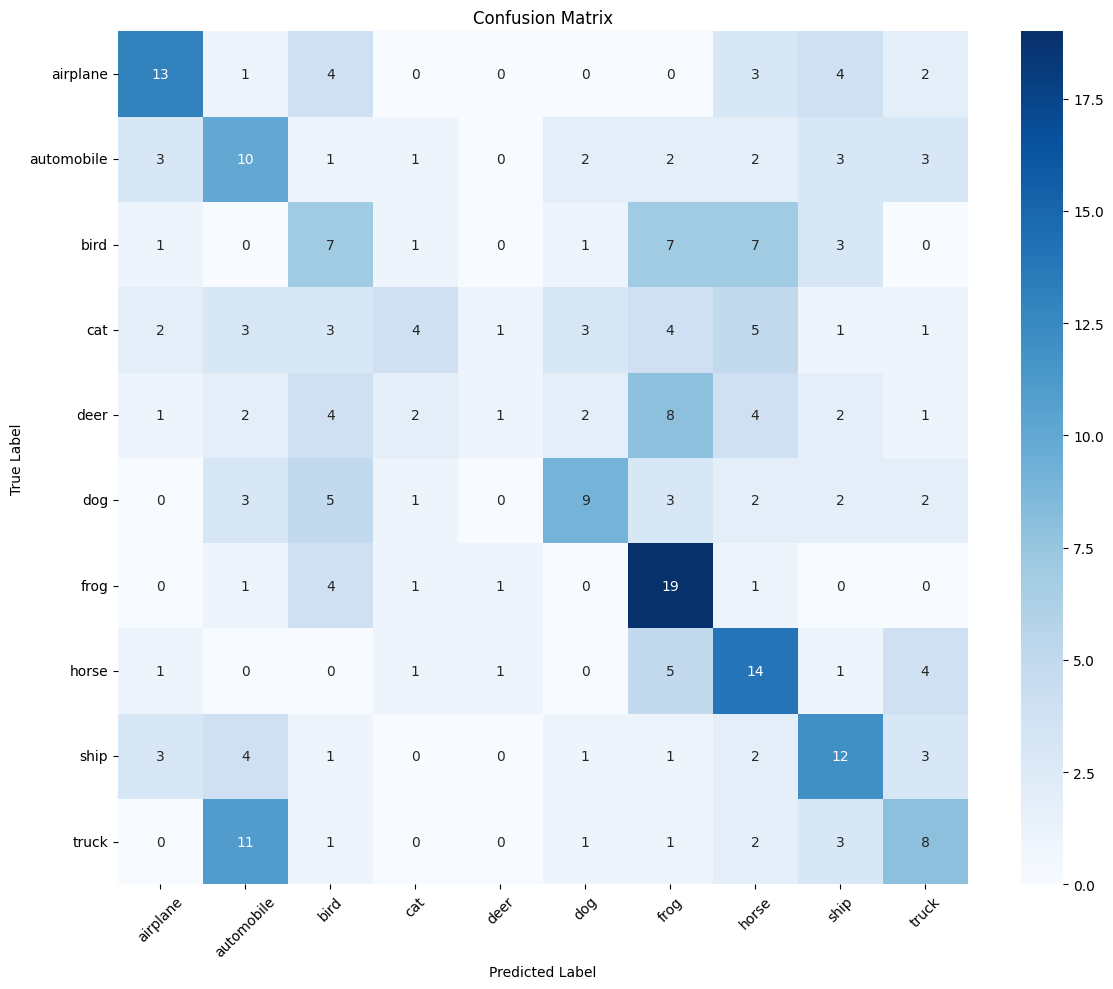

In [ ]:
# --- 9. Comprehensive Evaluation ---
# Classification Report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(test_labels, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Testing on sample images from test set...


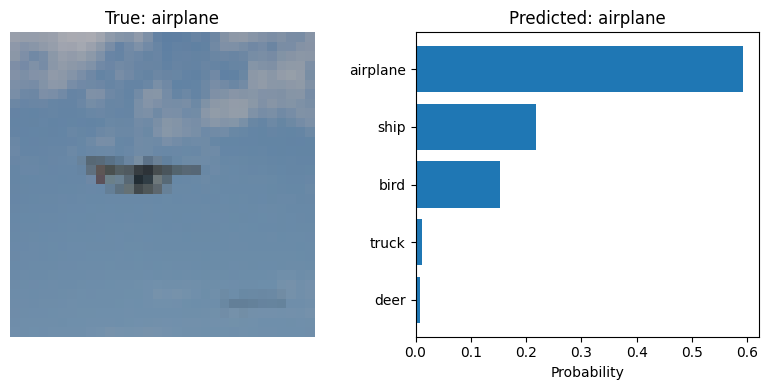

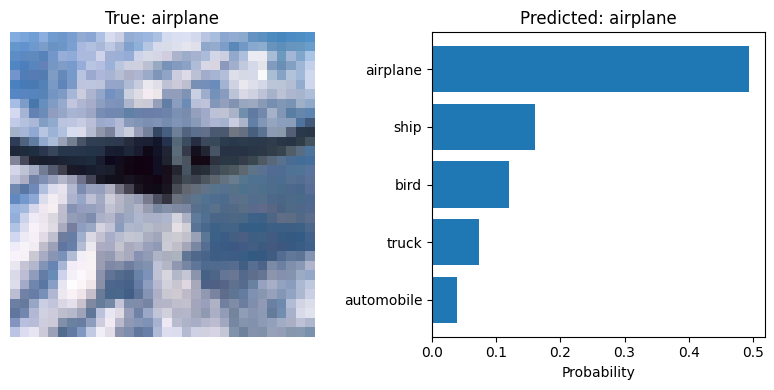

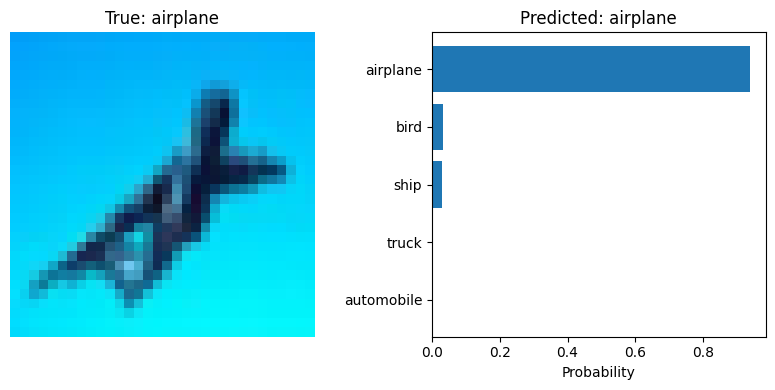

In [ ]:
# --- 10. Demonstration: Test on Individual Images ---
def predict_image(model, image_path, transform, class_names, device):
    """Predict the class of a single image"""
    model.eval()
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top5_prob, top5_catid = torch.topk(probabilities, 5)

    # Display image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title('Input Image')

    # Display predictions
    plt.subplot(1, 2, 2)
    y_pos = np.arange(5)
    plt.barh(y_pos, top5_prob[0].cpu().numpy(), align='center')
    plt.yticks(y_pos, [class_names[i] for i in top5_catid[0].cpu().numpy()])
    plt.xlabel('Probability')
    plt.title('Top 5 Predictions')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Top 5 Predictions:")
    for i in range(5):
        print(f"{i+1}. {class_names[top5_catid[0][i].item()]}: {top5_prob[0][i].item()*100:.2f}%")

# Test on a few sample images from the test set
def test_sample_images(model, test_loader, class_names, num_samples=5):
    """Test the model on sample images from the test set"""
    model.eval()
    data_iter = iter(test_loader)
    images, labels = next(data_iter)

    for i in range(min(num_samples, len(images))):
        image = images[i]
        label = labels[i]

        # Denormalize for display
        image_denorm = image * 0.5 + 0.5
        image_denorm = image_denorm.numpy().transpose((1, 2, 0))

        # Predict
        with torch.no_grad():
            output = model(image.unsqueeze(0).to(device))
            probabilities = F.softmax(output, dim=1)
            _, predicted = torch.max(output, 1)

        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(image_denorm)
        plt.title(f'True: {class_names[label]}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        top5_prob, top5_catid = torch.topk(probabilities, 5)
        y_pos = np.arange(5)
        plt.barh(y_pos, top5_prob[0].cpu().numpy(), align='center')
        plt.yticks(y_pos, [class_names[i] for i in top5_catid[0].cpu().numpy()])
        plt.xlabel('Probability')
        plt.title(f'Predicted: {class_names[predicted.item()]}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

print("Testing on sample images from test set...")
test_sample_images(model, test_loader, class_names, num_samples=3)

In [ ]:
# --- 11. Save the Final Model ---

# Use the best_model_save_path defined earlier (e.g., in cell e45c559b)
# If best_model_save_path is not defined, use a default path
try:
    final_model_save_path = best_model_save_path
except NameError:
    final_model_save_path = '/content/drive/MyDrive/cinic10_final_model.pth'
    print(f"Warning: best_model_save_path not defined, saving to default path: {final_model_save_path}")


torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy # Note: test_accuracy might not be defined if the evaluation cell failed
}, final_model_save_path)

print(f"Model saved to Google Drive: {final_model_save_path}")
print("Implementation complete! The system is ready for demonstration.")

## CNN

In [19]:
# --- 5. Define the Convolutional Neural Network (CNN) Model ---
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate flattened size after convolutions and pooling
        # Assuming input size is 3x32x32
        self._to_linear = None
        self._get_conv_output_size()

        self.fc1 = nn.Linear(self._to_linear, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def _get_conv_output_size(self):
        # Helper function to calculate the output size of the convolutional layers
        # Pass a dummy tensor through the conv layers
        with torch.no_grad():
            x = torch.randn(1, 3, 32, 32)
            x = self.pool(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
            x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
            self._to_linear = x.view(x.size(0), -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn2(self.conv2(F.relu(self.bn1(self.conv1(x)))))))
        x = self.pool2(F.relu(self.bn4(self.conv4(F.relu(self.bn3(self.conv3(x)))))))
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.bn5(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Initialize model
model_cnn = CNNModel(num_classes).to(device)
print(model_cnn)

# Display model architecture summary
try:
    summary(model_cnn, (3, 32, 32))
except Exception as e:
    print(f"Could not display summary for CNN model: {e}")

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (bn5): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [20]:
# --- 6. Define Loss Function and Optimizer for CNN ---
criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.01, weight_decay=1e-4)
scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode='max', factor=0.5, patience=3)

print("CNN Loss function and optimizer defined.")

CNN Loss function and optimizer defined.


In [21]:
# --- Define Model Save Path in Google Drive for CNN ---
base_model_save_path_cnn = "/content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn" # @param {type:"string"}

# Generate a descriptor based on hyperparameters
try:
    data_percentage_descriptor = f"data{total_data_percentage}pct"
except NameError:
    data_percentage_descriptor = "data100pct" # Default if total_data_percentage is not defined

# Get the current learning rate from the optimizer
try:
    current_lr_cnn = optimizer_cnn.param_groups[0]['lr']
    lr_descriptor_cnn = f"lr{current_lr_cnn}".replace('.', '_') # Replace . with _ for filename
except NameError:
    lr_descriptor_cnn = "lr_N_A" # Default if optimizer_cnn is not defined

best_model_save_path_cnn = f"{base_model_save_path_cnn}_{data_percentage_descriptor}_{lr_descriptor_cnn}.pth"

print(f"Best CNN model will be saved to: {best_model_save_path_cnn}")

Best CNN model will be saved to: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth


In [22]:
# --- 7. Train the CNN Model ---
def train_model_cnn(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, save_path='/content/best_cnn_model.pth'):
    train_loss_history = []
    val_accuracy_history = []
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0

        train_loader_tqdm = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train CNN]', leave=False)
        for images, labels in train_loader_tqdm:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            train_loader_tqdm.set_postfix({'loss': running_loss / ((train_loader_tqdm.n + 1) * images.size(0))})


        epoch_loss = running_loss / len(train_loader.dataset)
        train_loss_history.append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0

        val_loader_tqdm = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Valid CNN]', leave=False)
        with torch.no_grad():
            for images, labels in val_loader_tqdm:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_accuracy = 100 * correct / total
        val_accuracy_history.append(epoch_val_accuracy)

        # Update learning rate
        scheduler.step(epoch_val_accuracy)

        # Save best model
        if epoch_val_accuracy > best_accuracy:
            best_accuracy = epoch_val_accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Saved best CNN model with accuracy {best_accuracy:.2f}% to {save_path}")


        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, '
              f'Val Accuracy: {epoch_val_accuracy:.2f}%')

    return train_loss_history, val_accuracy_history

print("Starting CNN training...")
# Pass the save path to the training function
try:
    best_model_save_path_cnn
except NameError:
    best_model_save_path_cnn = '/content/best_cnn_model.pth' # Default save path if not defined

train_loss_history_cnn, val_accuracy_history_cnn = train_model_cnn(
    model_cnn, train_loader, val_loader, criterion_cnn, optimizer_cnn, scheduler_cnn, num_epochs=30, save_path=best_model_save_path_cnn
)

Starting CNN training...


Saved best CNN model with accuracy 39.67% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [1/30], Loss: 1.9694, Val Accuracy: 39.67%


Saved best CNN model with accuracy 42.88% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [2/30], Loss: 1.6461, Val Accuracy: 42.88%


Saved best CNN model with accuracy 49.28% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [3/30], Loss: 1.5154, Val Accuracy: 49.28%


Epoch [4/30], Loss: 1.4461, Val Accuracy: 40.34%


Epoch [5/30], Loss: 1.3954, Val Accuracy: 47.91%


Epoch [6/30], Loss: 1.3609, Val Accuracy: 48.76%


Saved best CNN model with accuracy 50.74% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [7/30], Loss: 1.3408, Val Accuracy: 50.74%


Epoch [8/30], Loss: 1.3071, Val Accuracy: 47.37%


Epoch [9/30], Loss: 1.2856, Val Accuracy: 48.69%


Saved best CNN model with accuracy 56.13% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [10/30], Loss: 1.2699, Val Accuracy: 56.13%


Epoch [11/30], Loss: 1.2565, Val Accuracy: 56.13%


Epoch [12/30], Loss: 1.2383, Val Accuracy: 53.31%


Epoch [13/30], Loss: 1.2319, Val Accuracy: 54.96%


Epoch [14/30], Loss: 1.2183, Val Accuracy: 54.52%


Saved best CNN model with accuracy 60.14% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [15/30], Loss: 1.1050, Val Accuracy: 60.14%


Epoch [16/30], Loss: 1.0674, Val Accuracy: 57.46%


Saved best CNN model with accuracy 62.79% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [17/30], Loss: 1.0506, Val Accuracy: 62.79%


Saved best CNN model with accuracy 63.36% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [18/30], Loss: 1.0373, Val Accuracy: 63.36%


Epoch [19/30], Loss: 1.0231, Val Accuracy: 60.71%


Epoch [20/30], Loss: 1.0025, Val Accuracy: 61.94%


Epoch [21/30], Loss: 0.9899, Val Accuracy: 60.01%


Epoch [22/30], Loss: 0.9777, Val Accuracy: 62.81%


Saved best CNN model with accuracy 65.75% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [23/30], Loss: 0.8785, Val Accuracy: 65.75%


Epoch [24/30], Loss: 0.8398, Val Accuracy: 65.67%


Epoch [25/30], Loss: 0.7968, Val Accuracy: 64.29%


Epoch [26/30], Loss: 0.7911, Val Accuracy: 65.73%


Epoch [27/30], Loss: 0.7657, Val Accuracy: 64.45%


Saved best CNN model with accuracy 67.47% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [28/30], Loss: 0.6885, Val Accuracy: 67.47%


Epoch [29/30], Loss: 0.6342, Val Accuracy: 67.47%


Saved best CNN model with accuracy 67.97% to /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
Epoch [30/30], Loss: 0.6126, Val Accuracy: 67.97%


In [23]:
# --- 8. Evaluate the CNN Model on Test Set ---
def evaluate_model_cnn(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    test_loader_tqdm = tqdm(test_loader, desc='Evaluating CNN Model', leave=False)

    with torch.no_grad():
        for images, labels in test_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Load best model
model_cnn.load_state_dict(torch.load(best_model_save_path_cnn))
print("Loaded best CNN model for testing.")

# Get predictions
test_preds_cnn, test_labels_cnn = evaluate_model_cnn(model_cnn, test_loader)

# Calculate accuracy
test_accuracy_cnn = 100 * np.sum(np.array(test_preds_cnn) == np.array(test_labels_cnn)) / len(test_labels_cnn)
print(f'\nFinal CNN Test Accuracy: {test_accuracy_cnn:.2f}%')

Loaded best CNN model for testing.



Final CNN Test Accuracy: 67.26%


In [24]:
# --- Collect and Store Experiment Data for CNN ---
import datetime

# Get hyperparameters
try:
    current_lr_cnn = optimizer_cnn.param_groups[0]['lr']
except NameError:
    current_lr_cnn = 'N/A' # Default if optimizer_cnn is not defined

try:
    current_weight_decay_cnn = optimizer_cnn.param_groups[0]['weight_decay']
except NameError:
    current_weight_decay_cnn = 'N/A' # Default if optimizer_cnn is not defined

try:
    current_batch_size_cnn = batch_size
except NameError:
    current_batch_size_cnn = 'N/A' # Default if batch_size is not defined

try:
    current_num_epochs_cnn = 30 # Assuming 30 epochs from the train_model_cnn call
except NameError:
     current_num_epochs_cnn = 'N/A' # Default if not tracked

try:
    current_data_percentage = total_data_percentage # Use the same data percentage as defined earlier
except NameError:
    current_data_percentage = 100 # Default if total_data_percentage not defined


# Define the path to save the experiment results table in Google Drive
experiment_table_path_cnn = "/content/drive/MyDrive/cinic10_experiment_results_cnn.csv" # @param {type:"string"}


# Load existing experiment results if the file exists, otherwise create a new DataFrame
if os.path.exists(experiment_table_path_cnn):
    experiment_results_df_cnn = pd.read_csv(experiment_table_path_cnn)
    print(f"\nLoaded existing CNN experiment results from: {experiment_table_path_cnn}")
else:
    experiment_results_df_cnn = pd.DataFrame(columns=[
        'Timestamp',
        'Model Type',
        'Data Percentage',
        'Test Accuracy (%)',
        'Model Save Path',
        'Learning Rate',
        'Weight Decay',
        'Batch Size',
        'Num Epochs'
    ])
    print("\nCreated a new CNN experiment results table.")

# Create a new row for the experiment results
new_row_cnn = {
    'Timestamp': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'Model Type': 'CNN',
    'Data Percentage': current_data_percentage,
    'Test Accuracy (%)': test_accuracy_cnn,
    'Model Save Path': best_model_save_path_cnn,
    'Learning Rate': current_lr_cnn,
    'Weight Decay': current_weight_decay_cnn,
    'Batch Size': current_batch_size_cnn,
    'Optimizer': optimizer_cnn,
    'Num Epochs': current_num_epochs_cnn
}

# Append the new row to the DataFrame
experiment_results_df_cnn = pd.concat([experiment_results_df_cnn, pd.DataFrame([new_row_cnn])], ignore_index=True)

# Display the updated table
print("\nUpdated CNN Experiment Results Table:")
display(experiment_results_df_cnn)

# Save the updated table
try:
    experiment_table_path_cnn
    experiment_results_df_cnn.to_csv(experiment_table_path_cnn, index=False)
    print(f"CNN experiment results table saved to: {experiment_table_path_cnn}")
except NameError:
    print("Warning: experiment_table_path_cnn not defined. Skipping saving the CNN results table.")


Loaded existing CNN experiment results from: /content/drive/MyDrive/cinic10_experiment_results_cnn.csv

Updated CNN Experiment Results Table:


,Timestamp,Model Type,Data Percentage,Test Accuracy (%),Model Save Path,Learning Rate,Weight Decay,Batch Size,Num Epochs,Optimizer
0,2025-09-18 22:06:33,CNN,1,42.222222,/content/drive/MyDrive/Deep_Learning/prosit_1/...,0.00125,0.0001,128,30,NaN
1,2025-09-19 00:47:30,CNN,10,67.258602,/content/drive/MyDrive/Deep_Learning/prosit_1/...,0.00125,0.0001,128,30,Adam (\nParameter Group 0\n amsgrad: False\...


CNN experiment results table saved to: /content/drive/MyDrive/cinic10_experiment_results_cnn.csv



CNN Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.77      0.78       270
  automobile       0.68      0.67      0.68       270
        bird       0.63      0.62      0.62       272
         cat       0.53      0.54      0.53       270
        deer       0.62      0.64      0.63       270
         dog       0.55      0.46      0.50       270
        frog       0.81      0.75      0.78       270
       horse       0.77      0.76      0.77       270
        ship       0.68      0.73      0.70       271
       truck       0.66      0.79      0.72       270

    accuracy                           0.67      2703
   macro avg       0.67      0.67      0.67      2703
weighted avg       0.67      0.67      0.67      2703



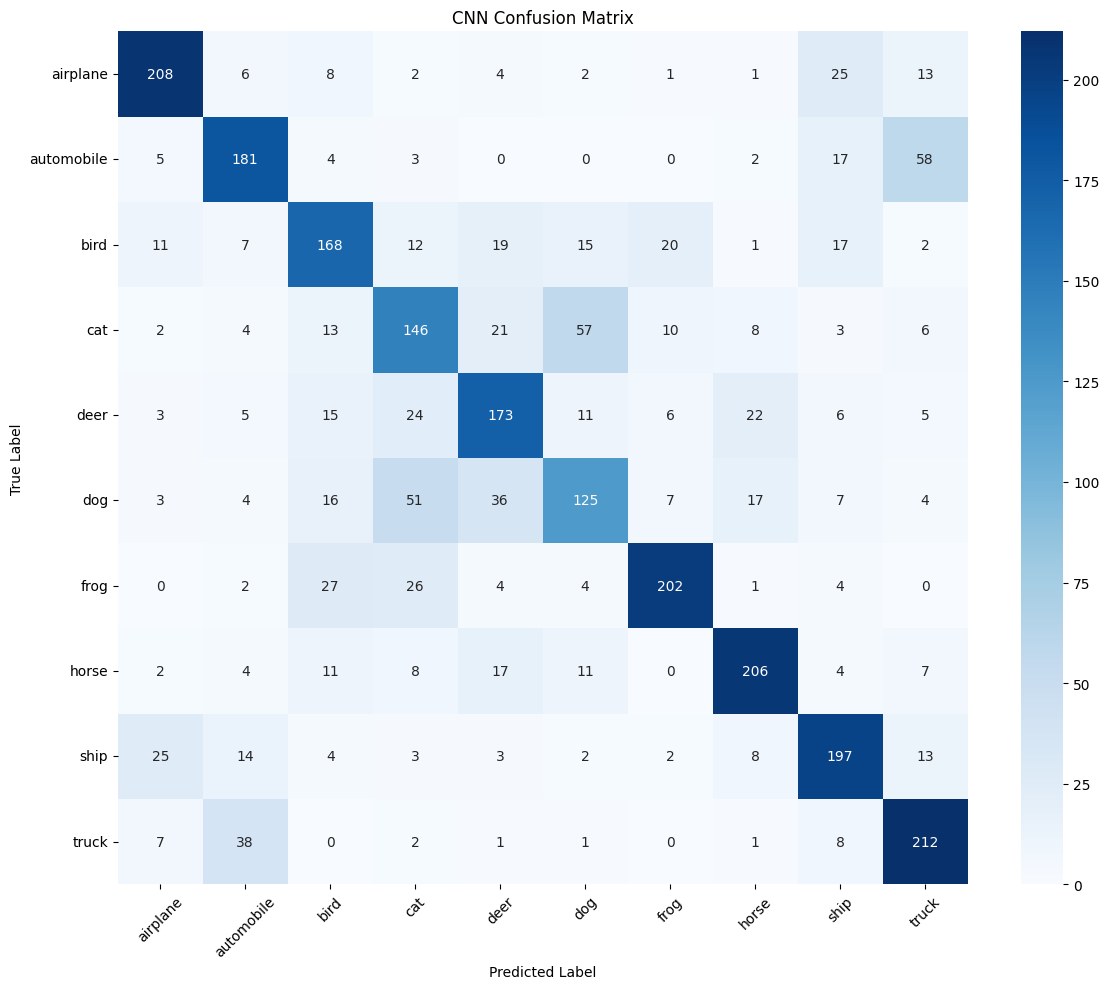


Testing CNN on sample images from test set...


NameError: name 'test_sample_images' is not defined

In [25]:
# --- 9. Comprehensive Evaluation for CNN ---
# Classification Report
print("\nCNN Classification Report:")
print(classification_report(test_labels_cnn, test_preds_cnn, target_names=class_names))

# Confusion Matrix
plt.figure(figsize=(12, 10))
cm_cnn = confusion_matrix(test_labels_cnn, test_preds_cnn)
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 10. Demonstration: Test on Individual Images for CNN ---
print("\nTesting CNN on sample images from test set...")
test_sample_images(model_cnn, test_loader, class_names, num_samples=3)

In [26]:
# --- 11. Save the Final CNN Model ---
try:
    final_model_save_path_cnn = best_model_save_path_cnn
except NameError:
    final_model_save_path_cnn = '/content/drive/MyDrive/cinic10_final_cnn_model.pth'
    print(f"Warning: best_model_save_path_cnn not defined, saving to default path: {final_model_save_path_cnn}")


torch.save({
    'model_state_dict': model_cnn.state_dict(),
    'class_names': class_names,
    'test_accuracy': test_accuracy_cnn # Use the CNN test accuracy
}, final_model_save_path_cnn)

print(f"\nCNN Model saved to Google Drive: {final_model_save_path_cnn}")
print("CNN implementation complete! The system is ready for demonstration.")


CNN Model saved to Google Drive: /content/drive/MyDrive/Deep_Learning/prosit_1/cinic-10_cnn_data10pct_lr0_01.pth
CNN implementation complete! The system is ready for demonstration.
